In [1]:
%pylab inline
%matplotlib inline

import os
os.chdir("/Users/Bya/git/predictEPL/MyFunctions/")
from dataIO import csv_dic_df

import time
import collections
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/Users/Bya/git/predictEPL/utils/")
sys.path.append("/Users/Bya/git/predictEPL/config/")
sys.path.append("/Users/Bya/git/predictEPL/WebScrapping/")

import paths
import espn_urls
import my_plot
import scrap_espn_gamecast
import emolex

import useful_methods
from useful_methods import FolderFiles
from useful_methods import csv_dic_df
from useful_methods import FilterDF
from useful_methods import PreprocessingTweet

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read Emolex
dic_emolex, dic_emolex_stemmed = emolex.EmolexDic()

# Read Soccer Emolex
dic_emolex_soccer, dic_emolex_stemmed_soccer = emolex.EmolexSoccerDic()

All Words: 14182
All Words: 14163


In [3]:
# choosing data
week = str(13)
GW = 'GW' + week
filenames = FolderFiles(GW + '/SingleGames', paths.READ_PATH_EXTRACTED_CSV, ends='.csv')
filenames

['Chelsea_vs_Norwich.csv',
 'City_vs_Liverpool.csv',
 'Crystal_vs_Sunderland.csv',
 'Everton_vs_Villa.csv',
 'Newcastle_vs_Leicester.csv',
 'Southampton_vs_Stoke.csv',
 'Swansea_vs_Bournemouth.csv',
 'Tottenham_vs_WestHam.csv',
 'WestBromwich_vs_Arsenal.csv']

In [4]:
# Set Game
filename = filenames[1]

# Read DF
os.chdir(paths.READ_PATH_EXTRACTED_CSV + GW + '/SingleGames')
df = csv_dic_df(filename)

start_time = time.time()

# [Filter] DF
dfFilter = FilterDF(df)

# # [Filtered] All, Non-Retweet
# dfFilterEmolex = emolex.CreateEmolexDF(dfFilter, dic_emolex, dic_emolex_stemmed)
# dfFilterEmolexNonRetweet = emolex.CreateEmolexDF(dfFilter[dfFilter['status'] != 'retweet'], dic_emolex, dic_emolex_stemmed)

# # [Filtered] Home, Away
dfFilterEmolexSoccerHome = emolex.CreateEmolexDF(dfFilter[dfFilter['side'] == 'home'], dic_emolex_soccer, dic_emolex_stemmed_soccer)
dfFilterEmolexSoccerAway = emolex.CreateEmolexDF(dfFilter[dfFilter['side'] == 'away'], dic_emolex_soccer, dic_emolex_stemmed_soccer)

# # [Filtered, Non ReTweet] Home, Away
# dfFilterEmolexNonRtHome = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'home') & (dfFilter['status'] != 'retweet')], dic_emolex, dic_emolex_stemmed)
# dfFilterEmolexNonRtAway = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'away') & (dfFilter['status'] != 'retweet')], dic_emolex, dic_emolex_stemmed)

# [Filtered, Non ReTweet] Home, Away
dfFilterEmolexSoccerNonRtHome = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'home') & (dfFilter['status'] != 'retweet')], dic_emolex_soccer, dic_emolex_stemmed_soccer)
dfFilterEmolexSoccerNonRtAway = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'away') & (dfFilter['status'] != 'retweet')], dic_emolex_soccer, dic_emolex_stemmed_soccer)

print("[Done]: %.2f" % (time.time() - start_time))

[Done]: 105.81


In [5]:
# Scrap Gamecast
url = espn_urls.MatchUrl(GW, filename)
dfGameCast = scrap_espn_gamecast.CreateEspnLiveCommentDF(url)

# Create Goal, Attack, Foul dics
goals_dic, attacks_dic_home, attacks_dic_away, fouls_dic_home, fouls_dic_away = scrap_espn_gamecast.CreateGAFdics(dfGameCast)

[Match]: Manchester City VS Liverpool
[Scrap Done]: 31.41 sec


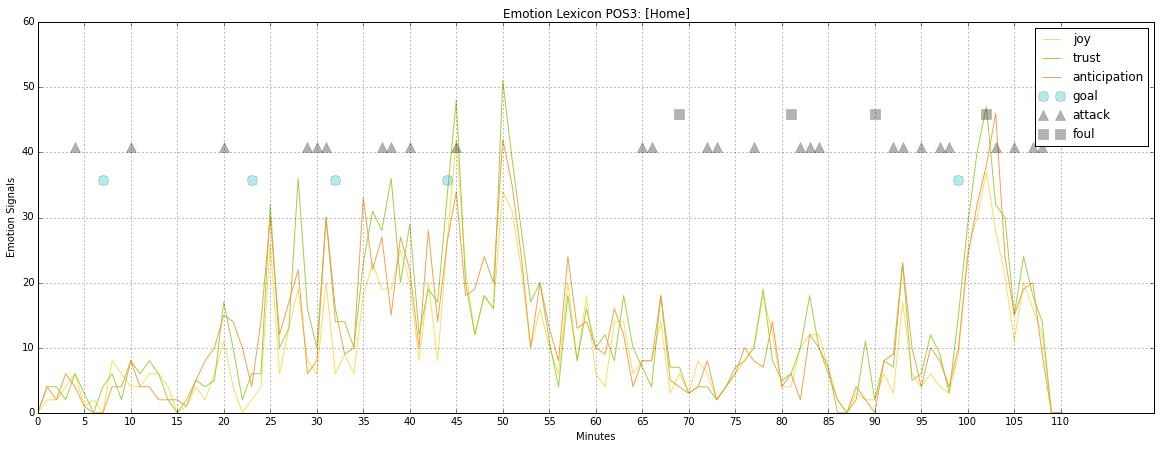

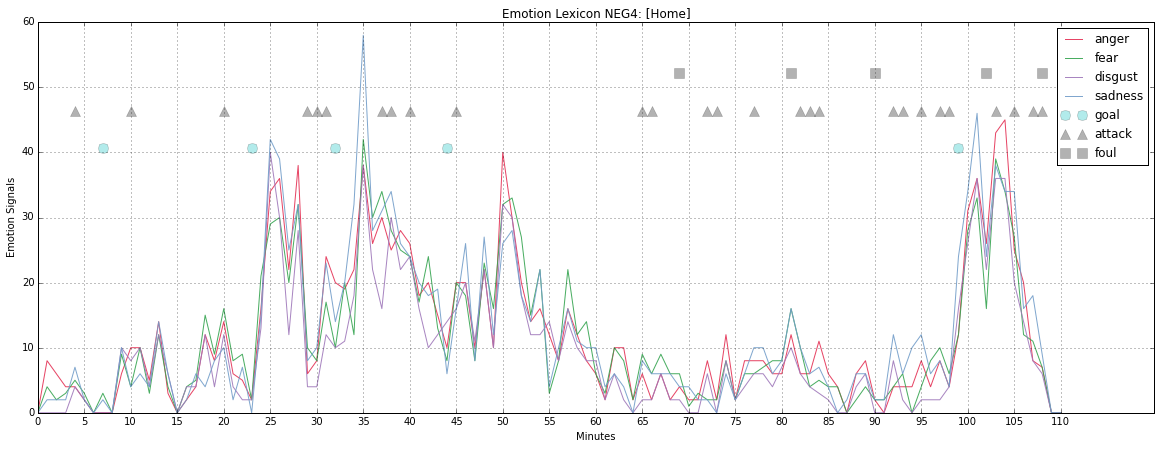

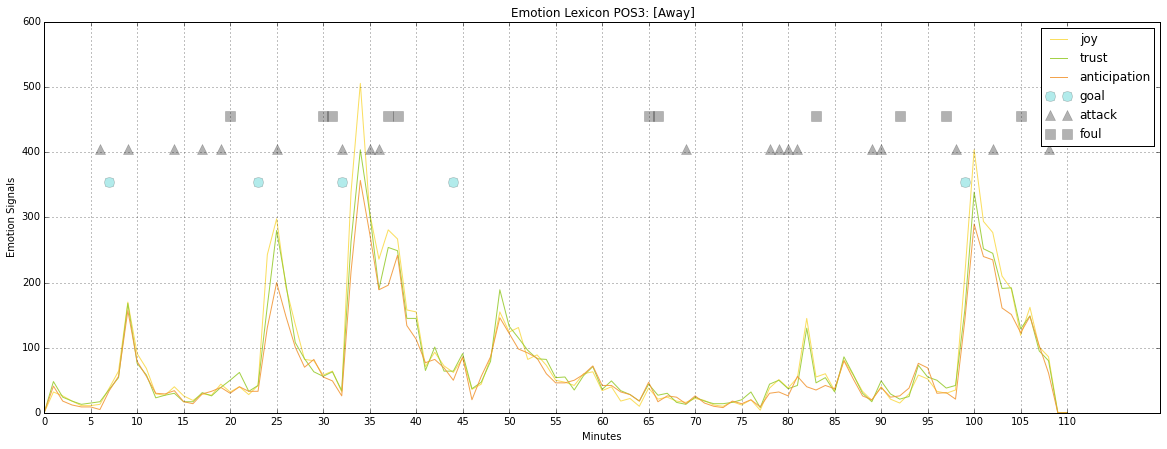

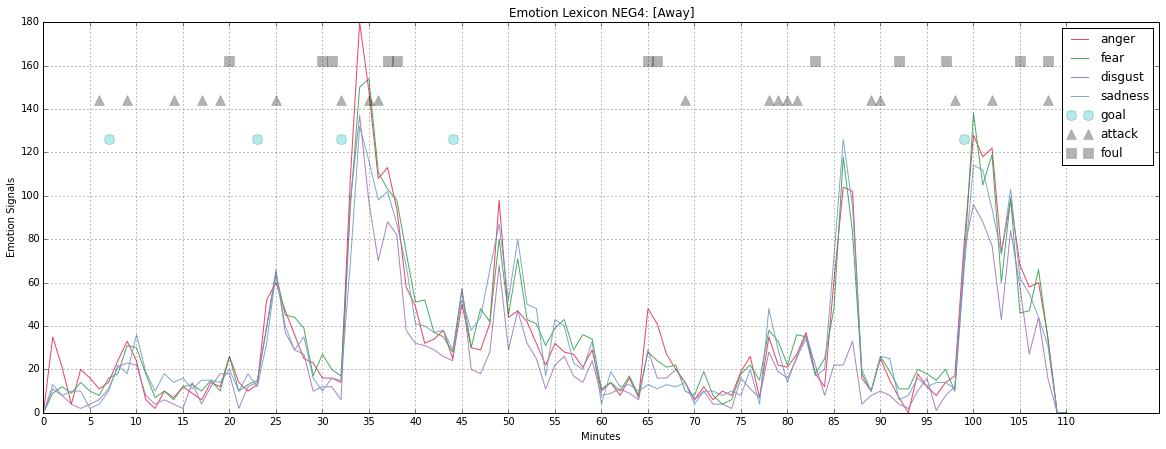

In [6]:
my_plot.Pos3Neg4(dfFilterEmolexSoccerNonRtHome, goals_dic, attacks_dic_home, fouls_dic_home, title='Home')
my_plot.Pos3Neg4(dfFilterEmolexSoccerNonRtAway, goals_dic, attacks_dic_away, fouls_dic_away, title='Away')

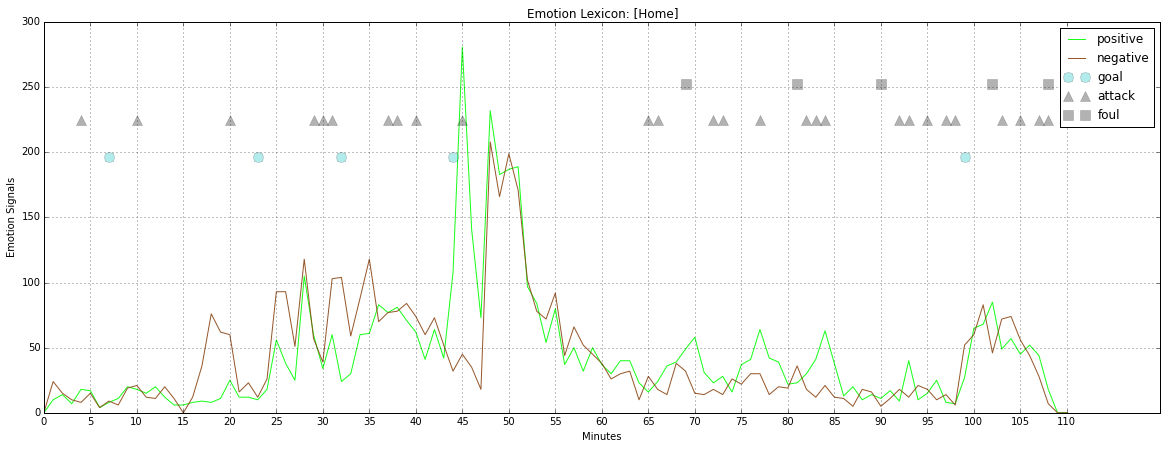

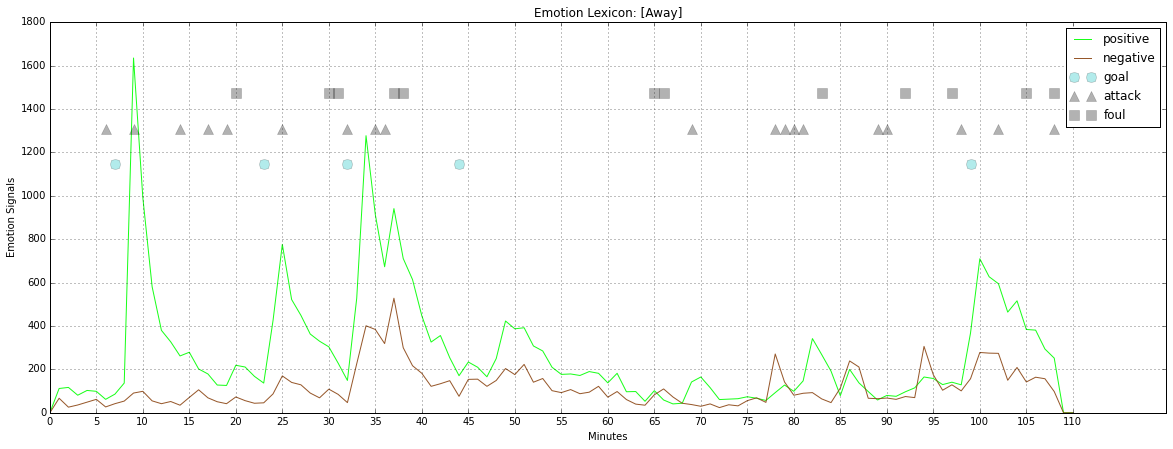

In [7]:
my_plot.EmolexCats(dfFilterEmolexSoccerHome, ['positive', 'negative'], goals_dic, attacks_dic_home, fouls_dic_home, 'Home')
my_plot.EmolexCats(dfFilterEmolexSoccerAway, ['positive', 'negative'], goals_dic, attacks_dic_away, fouls_dic_away, 'Away')

# my_plot.EmolexCats(dfFilterEmolexSoccerNonRtAway, ['positive', 'negative'], goals_dic, attacks_dic_away, fouls_dic_away, 'Away')

# Words Examination

In [8]:
# Set minute and side
start_minute = 99
end_minute = 110
side = 'home'

dfExamine = dfFilter.copy()
dfExamine['ith_minute'] = [int(ith_minte) for ith_minte in dfExamine['ith_minute']]

# extract tweets
tweets = list(dfExamine[
        (dfExamine['side'] == side) &
        (dfExamine['status'] != 'retweet') &
        (dfExamine['ith_minute'] >= start_minute) &
        (dfExamine['ith_minute'] <= end_minute)
    ]['text'])

print("[Tweets Number]: %s\n" % len(tweets))

# Create words lists. PreprocessingTweet
start_time = time.time()
all_words = []
all_words_stemmend = []
for tweet in tweets:
    words, words_stemmed = PreprocessingTweet(tweet)
    all_words += words
    all_words_stemmend += words_stemmed

print("[All Words]: %s" % (len(all_words)))
print("[Unique Words]: %s\n" % (len(set(all_words))))

print("[Most Common 10 Words]:")
useful_methods.ShowMostCommon(all_words)
print("\n")

print("[Emolex Words Count]:")
pprint(emolex.CountEmolexWords(dic_emolex_soccer, dic_emolex_stemmed_soccer, all_words, all_words_stemmend))
print("\n")


print("[Passed Time]: %.2f sec" % (time.time() - start_time))

[Tweets Number]: 447

[All Words]: 4140
[Unique Words]: 1416

[Most Common 10 Words]:
[('mcfc', 307),
 ('mancity', 122),
 ('liverpool', 112),
 ('@', 72),
 ('city', 61),
 ('http', 48),
 ('😂', 43),
 ('"', 41),
 ('fans', 37),
 ('today', 36)]


[Emolex Words Count]:
{'anger': 243,
 'anticipation': 220,
 'disgust': 201,
 'fear': 217,
 'joy': 189,
 'negative': 419,
 'positive': 352,
 'sadness': 258,
 'surprise': 134,
 'trust': 236}


[Passed Time]: 0.31 sec


In [15]:
cat = 'positive'

emolex_words = emolex.EmolexWords(dic_emolex_soccer, dic_emolex_stemmed_soccer, all_words, all_words_stemmend)

cat_words = emolex_words[cat]
useful_methods.ShowMostCommon(cat_words, 20)
len(cat_words)

[('good', 18),
 ('winning', 8),
 ('top', 8),
 ('sing', 6),
 ('money', 6),
 ('real', 5),
 ('deserved', 5),
 ('love', 5),
 ('hope', 5),
 ('happy', 4),
 ('defend', 4),
 ('absolute', 4),
 ('save', 3),
 ('defending', 3),
 ('deserve', 3),
 ('full', 3),
 ('word', 3),
 ('job', 3),
 ('proper', 3),
 ('respect', 3)]


218

In [16]:
dic_emolex['good']

{'anger': 0,
 'anticipation': 1,
 'disgust': 0,
 'fear': 0,
 'joy': 1,
 'negative': 0,
 'positive': 1,
 'sadness': 0,
 'surprise': 1,
 'trust': 1}

In [17]:
for tweet in tweets:
    if 'good' in tweet:
        print(tweet, '\n--------\n')

Think I could currently defend better than this #MCFC defence and I'm a fat fuck !!! #Shocking !!! Oh well good win for @ManUtd 
--------

Massively unimpressed by City today. Just don't look good enough to win anything. #mcfc 
--------

@StanCollymore @talkSPORT One swallow does not make a summer. Liverpool need consistent results as well very good ones. #Liverpool #ManCity 
--------

When #MCFC are good they are very, very good, but when they are bad, they are horrid. Shit even 
--------

lool #mancity what a good weekend of football 
--------

Not very good today. #MCFC. 
--------

Well, at least the city fans won't have far to go home. #wearefrommanchester #mcfc #notthatgoodtbh 
--------

It was never going to happen today. Liverpool has looked really good and we looked really bad  #mcfc 
--------

Well done Liverpool, done a job on us 2day. Pellegrini naive tonight. Game lost in 1st half. Certain back up players not good enough. #mcfc 
--------

RT @SSLJA: That's how good Aguero i

### Negation Marking

In [171]:
string = """
It was never going not to work, he wasn't thought. 
He did not play 3-3 so well, so he had to practice no some more. Not foobar!. I wasn't very good
"""

tweet = "It was never going to happen today. Liverpool has looked really good and we looked really bad  #mcfc"

In [176]:
import re

neglected_text = re.sub(
    r'''(?:n\'t|n\’t|never|no|nothing|nowhere|noone|none|not|havent|hasnt|hadnt|cant|couldnt|
    shouldnt|wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint)[\w\s#-]+[(.|:|;|!|?|,|\n)$]''', 
    lambda match: re.sub(r'(\s+)(\w+)', r'\1NEG_\2', match.group(0)), 
    string,
    flags=re.IGNORECASE)

print(neglected_text)


It was never NEG_going NEG_not NEG_to NEG_work, he wasn't NEG_thought. 
He did not NEG_play NEG_3-3 NEG_so NEG_well, so he had to practice no NEG_some NEG_more. Not NEG_foobar!. I wasn't NEG_very NEG_good



In [177]:
for tweet in tweets:
    if 'good' in tweet:
        print("\n---------------------")
        print(tweet)
        
        neglected_text = re.sub(
            r'''(?:n\'t|n\’t|never|no|nothing|nowhere|noone|none|not|havent|hasnt|hadnt|cant|couldnt|
            shouldnt|wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint)[\w\s#-]+[(.|:|;|!|?|,|\n)$]''', 
            lambda match: re.sub(r'(\s+)(\w+)', r'\1NEG_\2', match.group(0)), 
            tweet,
            flags=re.IGNORECASE)
        
        print("\n")
        print(neglected_text)
        


---------------------
Think I could currently defend better than this #MCFC defence and I'm a fat fuck !!! #Shocking !!! Oh well good win for @ManUtd


Think I could currently defend better than this #MCFC defence and I'm a fat fuck !!! #Shocking !!! Oh well good win for @ManUtd

---------------------
Massively unimpressed by City today. Just don't look good enough to win anything. #mcfc


Massively unimpressed by City today. Just don't NEG_look NEG_good NEG_enough NEG_to NEG_win NEG_anything. #mcfc

---------------------
@StanCollymore @talkSPORT One swallow does not make a summer. Liverpool need consistent results as well very good ones. #Liverpool #ManCity


@StanCollymore @talkSPORT One swallow does not NEG_make NEG_a NEG_summer. Liverpool need consistent results as well very good ones. #Liverpool #ManCity

---------------------
When #MCFC are good they are very, very good, but when they are bad, they are horrid. Shit even


When #MCFC are good they are very, very good, but when t